In [2]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

from scipy.stats import kruskal, f_oneway
from statsmodels.stats.multitest import multipletests
from scipy.cluster import hierarchy

from one.api import ONE

from reproducible_ephys_functions import figure_style, labs

In [3]:
import os
import numpy as np
from tqdm import tqdm
from pathlib import Path
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
ONE.setup(
    base_url="https://openalyx.internationalbrainlab.org", silent=True,
    cache_dir="/burg/stats/users/yz4123/Downloads"
)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [4]:
# res_path = Path("/burg/stats/users/yz4123/Downloads/results/")
# varis = ['choice', 'block', 'reward', 'whisker-motion-energy']
varis = ['choice', 'block', 'reward', 'wheel-speed']

In [5]:
# res_path = Path("/burg/stats/users/yz4123/Downloads/results/")
# varis = ['choice', 'block', 'reward', 'whisker-motion-energy']
varis = ['choice', 'block', 'reward', 'wheel-speed']

In [6]:
_, b, lab_cols = labs()

one = ONE()

# dec_d = {'stimside': 'stimside', 'choice': 'choice',
#         'feedback': 'feedback', 'whisker-motion-energy': 'whisker-motion-energy'}   

dec_d = {'stimside': 'stimside', 'choice': 'choice',
        'feedback': 'feedback', 'wheel-speed': 'wheel-speed'}   

In [7]:
for var in varis:
    df_list = []
    for fold_idx in [1, 2, 5]:
        res_path = Path(f"/burg/stats/users/yz4123/Downloads/results_fold_{fold_idx}/")
        configs = np.load(res_path/var/"multi-region-reduced_rank"/"configs.npy", allow_pickle=True)
        res_dict = {}
        for region in re_regions:
            res_dict[region] = {}
            path = res_path/var/"multi-region-reduced_rank"/region
            for fname in os.listdir(path):
                eid = fname[:-4]
                tmp = np.load(path/fname, allow_pickle=True).item()["test_metric"]
                res_dict[region][eid] = tmp

        df = pd.DataFrame(res_dict).reset_index()
        df_melted = pd.melt(df, id_vars=['index'], var_name='region', value_name='score')
        df_melted.columns = ["eid", "region", "score"]

        df_melted["unitcount"] = None
        for config in configs:
            mask = (df_melted["eid"] == config["eid"]) & (df_melted["region"] == config["region"])
            row_idx = df_melted[mask].index.item()
            df_melted.loc[row_idx, "unitcount"] = config["n_units"]

        print(df_melted[df_melted["score"] < -0.2]["eid"])
        # df_melted.drop(df_melted[df_melted["score"] < -0.2].index, inplace=True)
        
        df_list.append(df_melted)
    merged_df = pd.concat(df_list)
    # df = merged_df.groupby(["eid", "region"])["score"].apply(lambda x: np.nanmean(x)).reset_index()
    df = merged_df.groupby(["eid", "region"]).agg({"score": 'mean', "unitcount": "first"}).reset_index()
    df.to_parquet(f"{var}.parquet", engine="pyarrow")

Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
103    caa5dddc-9290-4e27-9f5e-575ba3598614
178    caa5dddc-9290-4e27-9f5e-575ba3598614
253    caa5dddc-9290-4e27-9f5e-575ba3598614
Name: eid, dtype: object
Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
Series([], Name: eid, dtype: object)
29     caa5dddc-9290-4e27-9f5e-575ba3598614
106    caa5dddc-9290-4e27-9f5e-575ba3598614
183    caa5dddc-9290-4e27-9f5e-575ba3598614
260    caa5dddc-9290-4e27-9f5e-575ba3598614
Name: eid, dtype: object


/local/ipykernel_3480941/2719415845.py:64: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


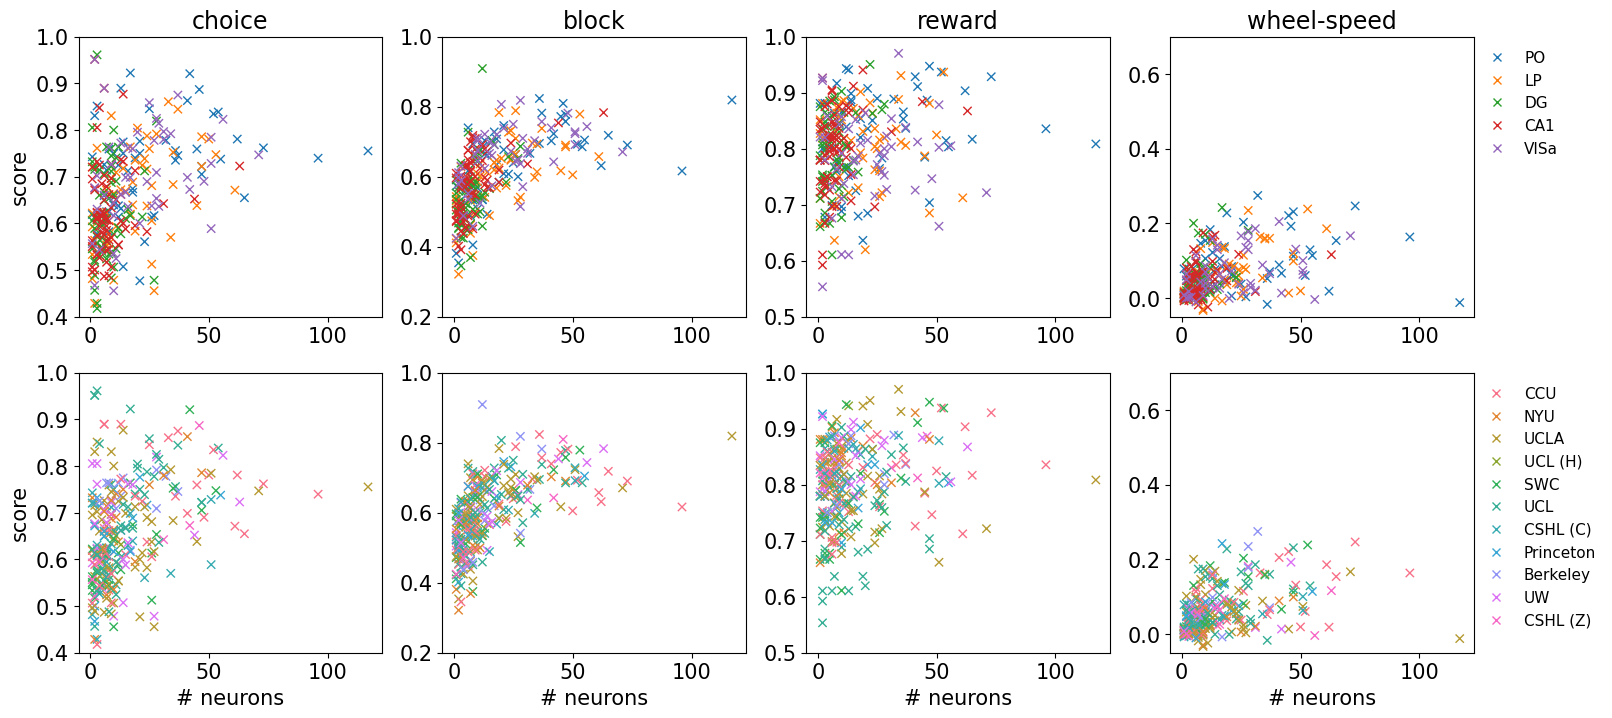

In [33]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# palette = [
#     "pink", "coral", "lightgreen", "cornflowerblue", "gold",
# ]

fig, axes = plt.subplots(2, len(varis), figsize=(18, 8))

for i, vari in enumerate(varis):
    data_file = f'{vari}.parquet'
    d = pd.read_parquet(data_file)
    pths = one.eid2path(d['eid'].values)
    d['lab'] = [b[str(p).split('/')[6]] for p in pths]
    d['subject'] = [str(p).split('/')[8] for p in pths]
    d = d.dropna(subset=['score', 'lab', 'region', 'subject'])
    sns.scatterplot(
        data=d, x="unitcount", y="score", hue="region", #size=15,
        ax=axes[0,i], marker='x', linewidth=1, #palette=palette,
    )
    axes[0,i].set_xlabel("", fontsize=20)
    if i == 0:
        axes[0,i].set_ylabel("score", fontsize=15)
        axes[0,i].legend(
            loc="upper right", bbox_to_anchor=(4.925, 1.), fontsize=11, ncol=1, frameon=False
        )
    else:
        axes[0,i].set_ylabel("", fontsize=20)
        axes[0,i].legend().set_visible(False)
    axes[0,i].set_title(vari, fontsize=17)
    axes[0,i].tick_params(labelsize=15)

    sns.scatterplot(
        data=d, x="unitcount", y="score", hue="lab", #size=15,
        ax=axes[1,i], marker='x', linewidth=1, #palette=palette,
    )
    axes[1,i].set_xlabel("# neurons", fontsize=15)
    if i == 0:
        axes[1,i].set_ylabel("score", fontsize=15)
        axes[1,i].legend(
            loc="upper right", bbox_to_anchor=(5.05, 1.), fontsize=11, ncol=1, frameon=False
        )
    else:
        axes[1,i].set_ylabel("", fontsize=20)
        axes[1,i].legend().set_visible(False)
    axes[1,i].set_title("", fontsize=20)
    axes[1,i].tick_params(labelsize=15)

    if i == 0:
        axes[0,i].set_ylim(0.4, 1.0)
        axes[1,i].set_ylim(0.4, 1.0)
    elif i == 3:
        axes[0,i].set_ylim(-.07, 0.4)
        axes[1,i].set_ylim(-.07, 0.4)
    elif i == 2:
        axes[0,i].set_ylim(0.55, 1.05)
        axes[1,i].set_ylim(0.55, 1.05)
    else:
        axes[0,i].set_ylim(0.3, 1.0)
        axes[1,i].set_ylim(0.3, 1.0)

# fig.subplots_adjust(top=0.922, bottom=0.088, left=0.094, right=0.982, hspace=0.2, wspace=0.211)

plt.tight_layout()
plt.savefig("perf_by_num_units_good_quality.png", dpi=300)
# plt.savefig("perf_by_num_units_all_units.png", dpi=600)
plt.show()

choice_VISa: p-value = 1.000
choice_CA1: p-value = 1.000
choice_DG: p-value = 1.000
choice_LP: p-value = 1.000
choice_PO: p-value = 1.000
block_VISa: p-value = 1.000
block_CA1: p-value = 1.000
block_DG: p-value = 1.000
block_LP: p-value = 1.000
block_PO: p-value = 1.000
reward_VISa: p-value = 1.000
reward_CA1: p-value = 1.000
reward_DG: p-value = 1.000
reward_LP: p-value = 1.000
reward_PO: p-value = 1.000
wheel-speed_VISa: p-value = 1.000
wheel-speed_CA1: p-value = 1.000
wheel-speed_DG: p-value = 1.000
wheel-speed_LP: p-value = 1.000
wheel-speed_PO: p-value = 1.000


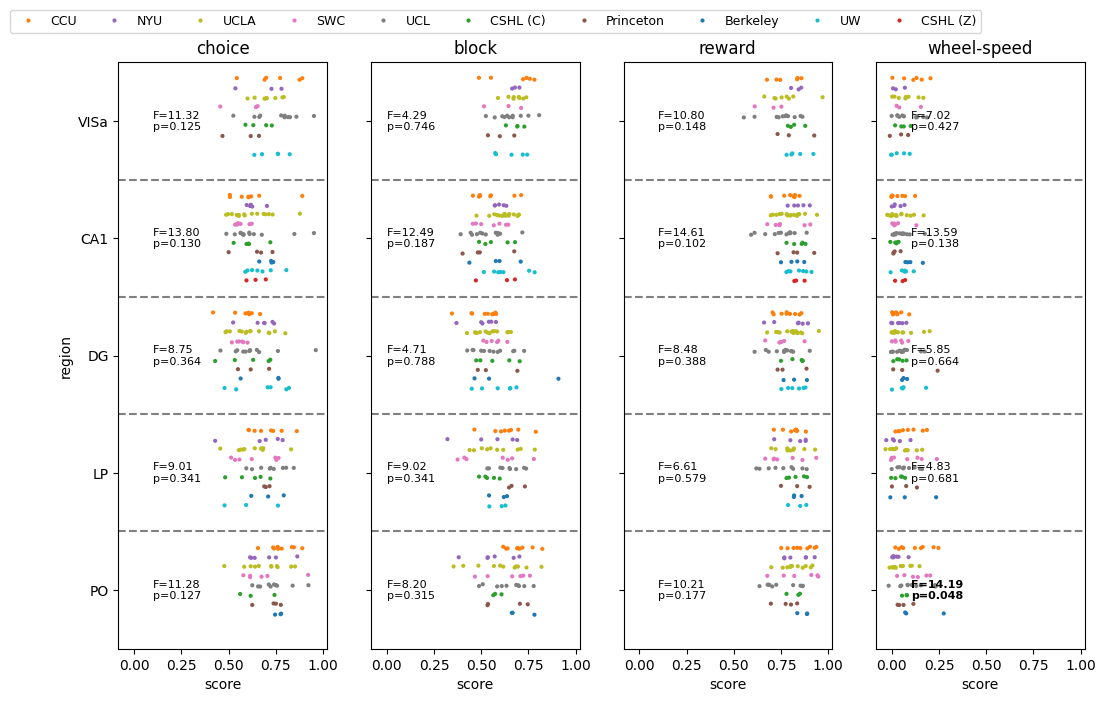

In [34]:

nscores=3
tt='stripplot'
sb='lab'

regs = ['VISa', 'CA1', 'DG', 'LP', 'PO']

# Use loaded data paths as in `pool_results_across_analyses`
# _, pa = get_allen_info()

# Pooled data paths
ana = 'dec'

ps = {}
fig, axs = plt.subplots(nrows=1, ncols=len(varis), sharex=True, sharey=True, figsize=(10.88, 7.03))
k = 0

for vari in varis:
    # Load pooled data based on `pool_results_across_analyses`

    data_file = f'{vari}.parquet'
    d = pd.read_parquet(data_file)
    pths = one.eid2path(d['eid'].values)
    d['lab'] = [b[str(p).split('/')[6]] for p in pths]
    d['subject'] = [str(p).split('/')[8] for p in pths]
    d = d.dropna(subset=['score', 'lab', 'region', 'subject'])

    # Plot logic
    if tt == 'mean_std':
        reg_stats = d.groupby('region')['score'].agg(
            mean_score=np.nanmean, std_score=np.nanstd, count_scores='count'
        ).reset_index()
        reg_stats = reg_stats[reg_stats['count_scores'] >= nscores]

        x = reg_stats['mean_score'].values
        y = reg_stats['std_score'].values
        regions = reg_stats['region'].values
        cols = [pa[region] for region in regions]
        sizes = reg_stats['count_scores'].values

        axs[k].scatter(x, y, color=cols, s=sizes if ana == 'dec' else sizes / 10)
        for i, reg in enumerate(regions):
            axs[k].annotate(f'  {reg}', (x[i], y[i]), fontsize=5, color=cols[i])

        axs[k].set_title(vari)
        axs[k].set_xlabel('mean')
        axs[k].set_ylabel('std')

    elif tt == 'stripplot':
        filtered_data = d[d['region'].isin(regs)]
        labs_counts = filtered_data.groupby([sb, 'region'])['score'].count().reset_index(name='score_count')
        valid_labs_regions = labs_counts[labs_counts['score_count'] >= nscores]
        filtered_data = pd.merge(filtered_data, valid_labs_regions[[sb, 'region']], on=[sb, 'region'])

        labss = np.unique(filtered_data[sb].values)
        palette = {lab: lab_cols[lab] for lab in labss} if sb == 'lab' else None

        sns.stripplot(x='score', y='region', hue=sb, palette=palette, data=filtered_data, jitter=True if sb == 'lab' else False, dodge=True, ax=axs[k], order=regs, size=3)
        for i, region in enumerate(regs):
            if i == len(regs) - 1:
                continue
            axs[k].axhline(i + 0.5, color='grey', linestyle='--')

        axs[k].set_title(vari)
        if sb == 'lab':
            if k != 0:
                axs[k].legend([], [], frameon=False)
            else:
                axs[k].legend(loc='lower left', fontsize=9, bbox_to_anchor=(-0.05, 1.04), ncols=len(labss)).set_draggable(True)

        # ANOVA
        labs = np.unique(d[sb].values)
        for reg in regs:
            scores_by_lab = [d[(d[sb] == lab) & (d['region'] == reg)]['score'].values for lab in labs]
            filtered_scores_by_lab = [lab_scores for lab_scores in scores_by_lab if lab_scores.size >= nscores]

            if len(filtered_scores_by_lab) < 2:
                continue

            # F, p = kruskal(*filtered_scores_by_lab)
            F, p = f_oneway(*filtered_scores_by_lab)
            ps[f"{vari}_{reg}"] = p
            m = np.max(np.concatenate(scores_by_lab))

            weight = 'bold' if p < 0.05 else 'normal'
            if vari == 'wheel-speed':
                x = 0.6
            elif vari == 'block':
                x = 0.
            else:
                x = 0.1
            axs[k].text(x, regs.index(reg), f'F={F:.2f}\np={p:.3f}', weight=weight, ha='left', va='center', fontsize=8)

    k += 1

if tt == 'stripplot':
    p_values_list = list(ps.values())
    _, ps_corrected, _, _ = multipletests(p_values_list, alpha=0.05, method='fdr_by')
    corrected_p_values_dict = dict(zip(ps.keys(), ps_corrected))
    for key, value in corrected_p_values_dict.items():
        print(f"{key}: p-value = {value:.3f}")

fig.subplots_adjust(top=0.922, bottom=0.088, left=0.094, right=0.982, hspace=0.2, wspace=0.211)

# plt.savefig("fig_from_Michael_all_unit.png", dpi=600)
plt.savefig("fig_from_Michael_good_unit.png", dpi=300)

plt.show()